In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree('drive/MyDrive/reformatted_data', '/content/data')

'/content/data'

In [ ]:
import os
import cv2
import xml.etree.ElementTree as pars
def area_of_intersection(coords1, coords2):
    """ Посчитаем площадь пересечения """

    x1, y1, x2, y2 = coords1
    x3, y3, x4, y4 = coords2

    # границы области пересечения
    left = max(x1, x3)  # левая
    bottom = max(y1, y3)  # нижняя
    right = min(x2, x4)  # правая
    top = min(y2, y4)  # верхняя

    width = right - left
    height = top - bottom

    if width <= 0 or height <= 0:
        area = 0
    else:
        area = width * height
    return area


def load_images_from_folder(folder):
    """ Загрузка названий(без расширения) и картинок cv в список"""

    im_list = []
    for filename in os.listdir(folder + "/images/"):
        img = cv2.imread(os.path.join(folder + "/images/" + filename))
        full_name = filename.split('.')
        part_name = full_name[0]
        if not img is None:
            im_list.append((part_name, img))
    return im_list

def load_objects(im_list, folder):
    """ Получаем список из: картинки, имени, объектов на них """
    object_list = []
    for pic in im_list:
        part_name = pic[0]
        img = pic[1]
        e = pars.parse(folder + '/annotations/' + part_name + '.xml')
        root = e.getroot()
        objects = []
        for object in root.findall('object'):
            name = object.find('name').text
            for box in object.findall('bndbox'):
                points = [int(box.find('xmin').text),
                                   int(box.find('ymin').text),
                                   int(box.find('xmax').text),
                                   int(box.find('ymax').text)]
            objects.append(points)
        object_list.append([img, part_name, objects])

    return object_list



def load_data():
    """ Кратенько загружаем """

    try:
        image_dir_test = 'data'
        test_image_list = load_images_from_folder(image_dir_test)
        test_object_list = load_objects(test_image_list, image_dir_test)
    except Exception as e:
      print(e)
      test_object_list = []
    return test_object_list

In [ ]:
result = load_data()

In [ ]:
import pandas as pd
df_data = []
for elem in result:
  if elem[2]:
    df_data.append((elem[1] + '.JPG', 1))
  else:
    df_data.append((elem[1] + '.JPG', 0))
df = pd.DataFrame(df_data, columns=['path', 'label'])

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(df, test_size=0.2)

In [ ]:
train_data.label.sum()

538

In [ ]:
import os
os.mkdir('train')
os.mkdir('val')
os.mkdir('train/0')
os.mkdir('train/1')
os.mkdir('val/0')
os.mkdir('val/1')

In [ ]:
for path, label in zip(train_data['path'], train_data['label']):
  shutil.copyfile(f'data/images/{path}', f'train/{label}/{path}')
for path, label in zip(val_data['path'], val_data['label']):
  shutil.copyfile(f'data/images/{path}', f'val/{label}/{path}')

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


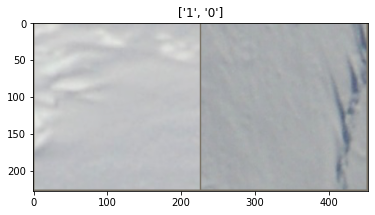

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    stat = {'losses': {'train': [], 'val': []},
              'accuracies': {'train': [], 'val': []}}
    predicted = []
    trues = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if epoch == num_epochs - 1:
                    predicted.extend(list(preds))
                    trues.extend(list(labels.data))
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            stat['losses'][phase].append(epoch_loss)
            stat['accuracies'][phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stat, trues, predicted

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
model_ft, stat, y_true, y_pred = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5455 Acc: 0.7263
val Loss: 0.3641 Acc: 0.8750

Epoch 1/24
----------
train Loss: 0.4313 Acc: 0.8153
val Loss: 0.2824 Acc: 0.8939

Epoch 2/24
----------
train Loss: 0.3754 Acc: 0.8381
val Loss: 0.1749 Acc: 0.9356

Epoch 3/24
----------
train Loss: 0.3374 Acc: 0.8589
val Loss: 0.1789 Acc: 0.9394

Epoch 4/24
----------
train Loss: 0.2970 Acc: 0.8778
val Loss: 0.1138 Acc: 0.9659

Epoch 5/24
----------
train Loss: 0.3312 Acc: 0.8769
val Loss: 0.2045 Acc: 0.9470

Epoch 6/24
----------
train Loss: 0.2874 Acc: 0.8835
val Loss: 0.1919 Acc: 0.9545

Epoch 7/24
----------
train Loss: 0.2574 Acc: 0.8949
val Loss: 0.1542 Acc: 0.9621

Epoch 8/24
----------
train Loss: 0.2435 Acc: 0.9119
val Loss: 0.1301 Acc: 0.9659

Epoch 9/24
----------
train Loss: 0.2530 Acc: 0.8977
val Loss: 0.1491 Acc: 0.9583

Epoch 10/24
----------
train Loss: 0.2525 Acc: 0.8968
val Loss: 0.1524 Acc: 0.9583

Epoch 11/24
----------
train Loss: 0.2277 Acc: 0.8920
val Loss: 0.1471 Acc: 0.9621

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


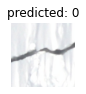

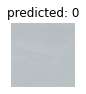

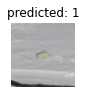

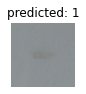

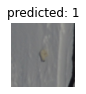

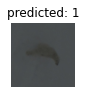

In [ ]:
visualize_model(model_ft)

Text(0.5, 1.0, 'Losses')

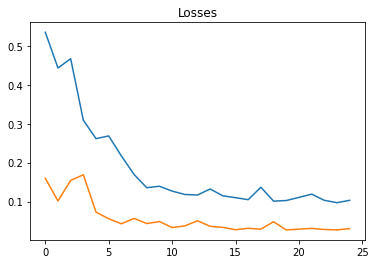

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(25), stat['losses']['train'], label='train')
plt.plot(range(25), stat['losses']['val'], label='val')
plt.title('Losses')

Text(0.5, 1.0, 'Accuracy')

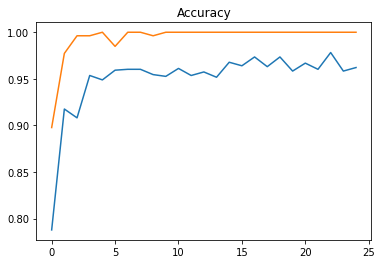

In [ ]:
plt.plot(range(25), stat['accuracies']['train'], label='train')
plt.plot(range(25), stat['accuracies']['val'], label='val')
plt.title('Accuracy')

In [ ]:
torch.save(model_ft, 'bear_model')

In [ ]:
import json
json.dump(stat, open('resnet_stat.json', 'w'))

In [ ]:
stat['accuracies']['train'] = list(map(lambda x: x.item(), stat['accuracies']['train']))
stat['accuracies']['val'] = list(map(lambda x: x.item(), stat['accuracies']['val']))

In [ ]:
from sklearn.metrics import recall_score, accuracy_score, precision_score
recall_score(list(map(lambda x: x.item(), y_true)), list(map(lambda x: x.item(), y_pred)))

0.9539375928677564

In [ ]:
len(y_true[-264:])

264

In [ ]:
model = torch.load('bear_class_model')

In [ ]:
for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  labels = labels.to(device)
  with torch.set_grad_enabled(False):
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


NameError: ignored

In [ ]:
preds

tensor([1, 0], device='cuda:0')